In [1]:
from FRDSolverClass import FRDsolver

import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
#Import all required functions required for the 2D-DRP for this notebook.
#(Running this code block is NOT required if FRD and PSF inputs are generated otherwise

#Note the testfile{}.csv files must be included if generating images with the 2D-DRP

############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/brentbelland/Desktop/Version_028d/2d_PSF_code/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

# lmfit 
# import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

from Zernike_Module import *

In [3]:
## Set up input images


##Change these values to modify the output

positionvalt = 64
FRDrealt = 0.023
knownFRDlist = np.linspace(0.015,0.030)

##Function defintions to generate images to test with

def get_PSF_parameters(FRDval,Defocusval,Positionval):
    testfile = pd.read_csv("testfile{}.csv".format(Defocusval))
    testfile = testfile.iloc[Positionval]
    testfile['z4':'z22']= testfile['z4':'z22']
    testfile['frd_sigma'] = FRDval
    PSF_parameters = testfile.values
    PSF_parameters = PSF_parameters[:-2]
    return PSF_parameters

def generate_specific_image_position(position,FRD):
    sci_image = 10*np.random.rand(50,50)
    var_image = sci_image
    model3 = LN_PFS_single(sci_image,var_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536)
    #FRD = 0.015+0.015*np.random.rand()
    res=model3(get_PSF_parameters(FRD,'0',position),return_Image=True) #Position is arbitrarily set by random sci_image input and Neven's code
    In_focus = res[1]

    return In_focus

def generate_image_of_known_FRD(imagetosolve,arrayofFRD,positionvalue):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = get_model_image_compare_position(imagetosolve,FRD,positionvalue)
        imagearrayofFRD.append(newimage)
    return imagearrayofFRD

def generate_image_of_known_FRD_simple(arrayofFRD,positionvalue,magnitude):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = generate_specific_image_position(positionvalue,FRD)
        newimage = magnitude/np.sum(newimage)*newimage
        imagearrayofFRD.append(newimage)
    return imagearrayofFRD

def get_model_image_compare_position(science_image,guessFRD,position):
    #if isinstance(science_image[0][0],list):
    #    print(science_image)
    variance_image = 0.99*science_image+40*np.ones(np.shape(science_image))
    model4 = LN_PFS_single(science_image,variance_image,dithering=1,save=0,zmax=22,verbosity=0,npix=1536,fit_for_flux=True)
    res=model4(get_PSF_parameters(guessFRD,'0',position),return_Image=True) #xy position is fit for by Neven's code
    In_focus = res[1]
    #print(res[-1])
    
    return In_focus

In [ ]:
## Generation of the images and FRD list 

newimaget = generate_specific_image_position(positionvalt,FRDrealt) # This is the image to test against.
imagerealt = 500000/np.sum(newimaget)*newimaget #Flux calibration generally corresponding to 50000 counts in brightest image
imagelist = generate_image_of_known_FRD(imagerealt,knownFRDlist,positionvalt)

In [38]:
##Adding noise

def addnoise(image):
    var_image=image+40 #40 accounts for read noise, but keep in mind that the input images must be scaled properly too...
    artificial_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
    for i in range(len(artificial_noise_data)):
        for j in range(len(artificial_noise_data)):
            artificial_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
    return image+artificial_noise_data

def generate_image_of_known_FRD_noisy(imagetosolve,arrayofFRD,positionvalue):
    imagearrayofFRD = []
    for FRD in arrayofFRD:
        #print(FRD)
        newimage = get_model_image_compare_position(imagetosolve,FRD,positionvalue)
        imagearrayofFRD.append(addnoise(newimage))
    return imagearrayofFRD

In [5]:
imagenoiset = addnoise(imagerealt)
imagelistnoise = generate_image_of_known_FRD_noisy(imagerealt,knownFRDlist,positionvalt)

In [126]:
#Generate an image with an FRD to solve for, plus a set of known FRD. Takes a long time to run on my computer

magnitude = 500000

FRDimageset = {
    "FRDtofind" : {},
    "knownFRDlist" : {}
}

knownFRDlist = np.linspace(0.015,0.030,10)

for position in range(120):
    FRDimage = generate_specific_image_position(position,FRDrealt)
    FRDimage = magnitude/np.sum(FRDimage)*FRDimage
    FRDimageset["FRDtofind"][position] = FRDimage
    FRDimageset["knownFRDlist"][position] = generate_image_of_known_FRD(FRDimage,knownFRDlist,position)

In [140]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#FRDimageset = save_obj(FRDimageset,'DetectorFRDs_noiseless') #Alternatively can load a presaved version across the detector    
    
FRDimageset = load_obj('DetectorFRDs_noiseless_generated') #Alternatively can load a presaved version across the detector
FRDimagesetmany = load_obj('DetectorFRDs_noiseless_generated_many') #Alternatively can load a presaved version across the detector
FRDimagesetmanysim = load_obj('DetectorFRDs_noiseless_generated_simulation_many') #Alternatively can load a presaved version across the detector





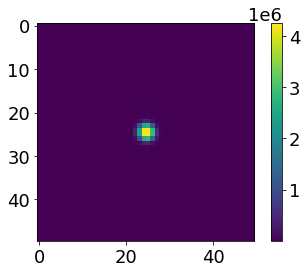

Minimum FRD is 0.02387755102040816 and within range 0.021734693877551017 to 0.02663265306122449


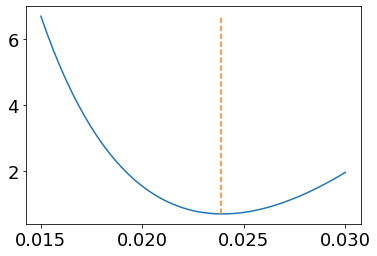

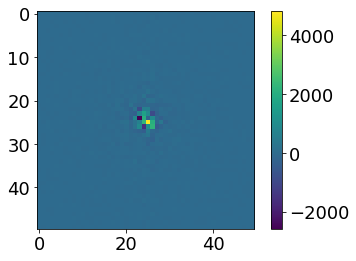

0.004897959183673473


In [252]:
## Example class test

position = 45
"""
knownFRDlist = np.linspace(0.015,0.030,10)

imagelist = np.array(FRDimageset["knownFRDlist"][position])

imagetosolve = addnoise(FRDimageset["FRDtofind"][position])"""



"""knownFRDlist = np.linspace(0.015,0.030,50)

imagelist = np.array(FRDimagesetmany["knownFRDlist"][position])

imagetosolve = addnoise(FRDimagesetmany["FRDtofind"][position])
"""


knownFRDlist = np.linspace(0.015,0.030,50)

imagelist = 100*np.array(FRDimagesetmanysim["knownFRDlist"][position])

imagetosolve = addnoise(100*FRDimagesetmanysim["FRDtofind"][position])




plt.imshow(imagetosolve)
plt.colorbar()
plt.show()

testFRD = FRDsolver(knownFRDlist, imagelist, imagetosolve)

(residuallist, minFRD,uncertaintyrange) = testFRD.find_FRD_compare_positions(knownFRDlist, imagelist, imagetosolve)

plt.plot(knownFRDlist,residuallist)
plt.plot([minFRD,minFRD],[np.min(residuallist),np.max(residuallist)],'--')
plt.show()

plt.imshow(imagetosolve - imagelist[knownFRDlist == minFRD][0])
plt.colorbar()
plt.show()

print(uncertaintyrange)

In [ ]:
FRDrange = []
uncertaintyplotlist = []
FRDplotlist = []
for position in range(120):

    knownFRDlist = np.linspace(0.015,0.030,10)

    imagelist = np.array(FRDimageset["knownFRDlist"][position])

    imagetosolve = FRDimageset["FRDtofind"][position]

    testFRD = FRDsolver(knownFRDlist, imagelist, imagetosolve)

    (residuallist, minFRD,uncertaintyrange) = testFRD.find_FRD_compare_positions(knownFRDlist, imagelist, imagetosolve)

    #FRDrange.append(testFRD.returnFRDrange())
    FRDplotlist.append(minFRD)
    uncertaintyplotlist.append(uncertaintyrange)

In [245]:
def get_HgAr_parameters(Positionval):
    testfile = pd.read_csv("finalHgArfile.csv")
    testfile = testfile.iloc[Positionval]
    #testfile['z4':'z22']= testfile['z4':'z22']
    #testfile['frd_sigma'] = FRDval
    PSF_parameters = testfile.values
    #print(PSF_parameters[0])
    #print(PSF_parameters[1])
    #print(PSF_parameters[2])
    PSF_parameters = PSF_parameters[[6,2]]
    return PSF_parameters

xval = np.zeros(120)
yval = np.zeros(120)
for index in range(120):
    position = get_HgAr_parameters(index)
    xval[index] = position[0]
    yval[index] = position[1]

Minimum FRD is 0.02333333333333333 and within range 0.018333333333333333 to 0.03
Minimum FRD is 0.021666666666666667 and within range 0.018333333333333333 to 0.028333333333333332
Minimum FRD is 0.021666666666666667 and within range 0.018333333333333333 to 0.026666666666666665
Minimum FRD is 0.021666666666666667 and within range 0.016666666666666666 to 0.03
Minimum FRD is 0.024999999999999998 and within range 0.019999999999999997 to 0.03
Minimum FRD is 0.02333333333333333 and within range 0.016666666666666666 to 0.03
Minimum FRD is 0.02333333333333333 and within range 0.018333333333333333 to 0.03
Minimum FRD is 0.019999999999999997 and within range 0.016666666666666666 to 0.03
Minimum FRD is 0.021666666666666667 and within range 0.018333333333333333 to 0.03
Minimum FRD is 0.021666666666666667 and within range 0.021666666666666667 to 0.024999999999999998
Minimum FRD is 0.02333333333333333 and within range 0.021666666666666667 to 0.02333333333333333
Minimum FRD is 0.02333333333333333 and 

Minimum FRD is 0.021666666666666667 and within range 0.015 to 0.03
Minimum FRD is 0.024999999999999998 and within range 0.021666666666666667 to 0.028333333333333332
Minimum FRD is 0.02333333333333333 and within range 0.021666666666666667 to 0.026666666666666665
Minimum FRD is 0.021666666666666667 and within range 0.019999999999999997 to 0.024999999999999998
Minimum FRD is 0.021666666666666667 and within range 0.018333333333333333 to 0.026666666666666665
Minimum FRD is 0.02333333333333333 and within range 0.019999999999999997 to 0.024999999999999998
Minimum FRD is 0.02333333333333333 and within range 0.019999999999999997 to 0.026666666666666665
Minimum FRD is 0.02333333333333333 and within range 0.019999999999999997 to 0.026666666666666665
Minimum FRD is 0.021666666666666667 and within range 0.018333333333333333 to 0.026666666666666665
Minimum FRD is 0.024999999999999998 and within range 0.019999999999999997 to 0.03
Minimum FRD is 0.021666666666666667 and within range 0.0183333333333333

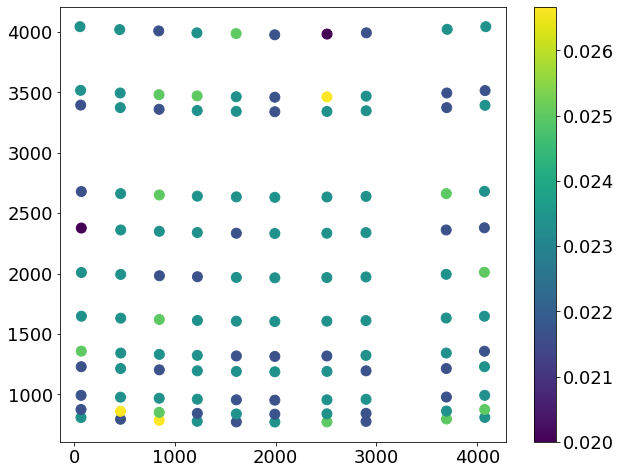

0.023041666666666665
0.001210725601233194


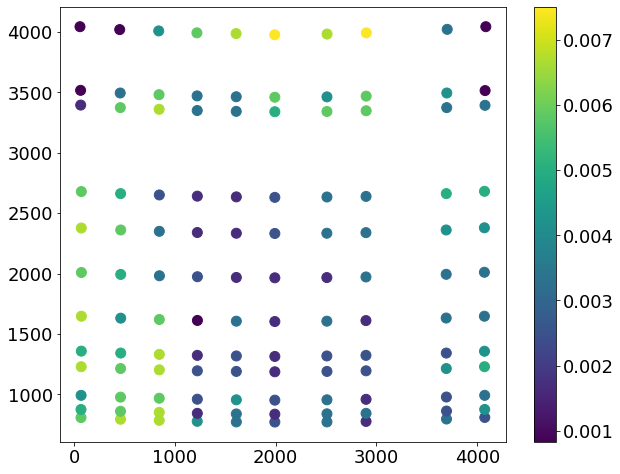

In [257]:
FRDrange = []
uncertaintyplotlist = []
FRDplotlist = []
for position in range(120):

    knownFRDlist = np.linspace(0.015,0.030,10)

    imagelist = 100*np.array(FRDimageset["knownFRDlist"][position])

    imagetosolve = addnoise(100*FRDimageset["FRDtofind"][position])

    testFRD = FRDsolver(knownFRDlist, imagelist, imagetosolve)

    (residuallist, minFRD,uncertaintyrange) = testFRD.find_FRD_compare_positions(knownFRDlist, imagelist, imagetosolve)

    #FRDrange.append(testFRD.returnFRDrange())
    FRDplotlist.append(minFRD)
    uncertaintyplotlist.append(uncertaintyrange)

plt.figure(figsize=(10,8))
plt.scatter(xval,yval,c=np.array(FRDplotlist),s=100)
plt.colorbar()
plt.show()

print(np.mean(FRDplotlist))
print(np.std(FRDplotlist))

plt.figure(figsize=(10,8))
plt.scatter(xval,yval,c=np.array(uncertaintyplotlist)/2,s=100)
plt.colorbar()
plt.show()

In [258]:
import os
os.getcwd()

'/Users/brentbelland/Desktop/FRDSolverClass'